# 2025 CITS4012 Group 9 – An Ablation Study on NLI Classifier Attention

<a href="https://colab.research.google.com/github/Kaichao-Zheng/CITS4012-NLP/blob/main/CITS4012_Group9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborators

| Uni ID   | Student Name  | GitHub Username                                   |
| -------- | ------------- | ------------------------------------------------- |
| 24141207 | Kaichao Zheng | [Kaichao-Zheng](https://github.com/Kaichao-Zheng) |
| 24645175 | Ziqi Meng     | [jiongge39](https://github.com/jiongge39)         |
| 23998001 | Yanglei Yuan  | [LeoYuan0225](https://github.com/LeoYuan0225)     |

# 0. Setup (1+1 min)

> NOTE:
>
> In Google Colab, an ERROR would occur due to incompatibility of the latest versions of `numpy` and `scipy`.
>
> Simply **restart the runtime** to use the newly downgraded versions.

In [ ]:
%pip install word2number
%pip install contractions
%pip install nltk
%pip install pandas
%pip install gensim
%pip install matplotlib
%pip install wordcloud
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


# 1. Overview

We implemented three different model architectures:

* [The Vanilla Bi-LSTM NLI Classifier](#scrollTo=67TQJgOJ_lF1)

* [The Bi-LSTM Self-Attention NLI Classifier](#scrollTo=BhSE5ON4_r0C)

* [The Transformer Encoder NLI](#scrollTo=E4w_n2P2_xxm)

# 2. Data Preprocessing

## 2.1 Load JSON files from GitHub



In [ ]:
# Define JSON dataset paths
base_url = "https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/"

train_file = base_url + "train.json"
val_file = base_url + "validation.json"
test_file = base_url + "test.json"

# Quick check
print("✅ Dataset URLs:")
print("Train:\t", train_file)
print("Val:\t", val_file)
print("Test:\t", test_file)

✅ Dataset URLs:
Train:	 https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/train.json
Val:	 https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/validation.json
Test:	 https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/test.json


In [ ]:
import pandas as pd

# Working dataframes
train_df = pd.read_json(train_file)
val_df = pd.read_json(val_file)
test_df = pd.read_json(test_file)

# Keep original copies
source_train_df = train_df.copy()
source_val_df = val_df.copy()
source_test_df = test_df.copy()

# Sneak peek
pd.set_option("display.max_colwidth", 30)

print(train_df.head())
# print(val_df.head())
# print(test_df.head())

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

pd.reset_option("display.max_colwidth")

                         premise                     hypothesis    label
0  Pluto rotates once on its ...  Earth rotates on its axis ...  neutral
1  ---Glenn =================...  Earth rotates on its axis ...  entails
2  geysers - periodic gush of...  The surface of the sun is ...  neutral
3  Facts: Liquid water drople...  Evaporation is responsible...  entails
4  By comparison, the earth r...  Earth rotates on its axis ...  entails
Train size: 23088
Val size: 1304
Test size: 2126


## 2.2 Define difference viewer

In [ ]:
import html
from difflib import SequenceMatcher
from IPython.display import display, HTML

def verify_print(source_df, cleaned_df, tag, num, col, idx_src ,idx_now, kept=False):
  status = "Kept " if kept else "Reindexed"
  print(f"{tag} {num}:\tidx_src: {idx_src}\t{source_df[col][idx_src]}")
  print(f"{status} {num}:\tidx_now: {idx_now}\t{cleaned_df[col][idx_now]}")
  print()

# You can enable dark mode by replacing default "light" here
def verify_diff(source_df, cleaned_df, tag, num, col, index, kept=False, theme="light"):
  if theme == "light":
    bg = "#fafafa"; fg = "#000000"
    del_bg = "#ffdddd"; ins_bg = "#ddffdd"
    del_fg = "#aa0000"; ins_fg = "#006600"
  else:
    bg = "#1e1e1e"; fg = "#e0e0e0"
    del_bg = "#662222"; ins_bg = "#224422"
    del_fg = "#ff9999"; ins_fg = "#99ff99"

  status = "Kept" if kept else "Fixed"

  original = source_df[col][index]
  cleaned = cleaned_df[col][index]

  matcher = SequenceMatcher(None, original, cleaned)

  html_original = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{tag} {num}:</b> """
  html_cleaned = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{status} {num}:</b> """

  for tag, i1, i2, j1, j2 in matcher.get_opcodes():
    orig_text = original[i1:i2].replace(" ", "&nbsp;")
    clean_text = cleaned[j1:j2].replace(" ", "&nbsp;")

    if tag == 'equal':
      html_original += orig_text
      html_cleaned += clean_text
    elif tag == 'delete':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
    elif tag == 'insert':
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"
    elif tag == 'replace':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"

  html_original += "</div>"
  html_cleaned += "</div>"

  display(HTML(html_original + html_cleaned + "<hr/>"))

## 2.3 Data cleansing

In principle, the data cleansing rules are derived solely from the training set to prevent information leakage.

This design intentionally preserves out-of-vocabulary (OOV) cases in the validation and test sets, which are represented by \<UNK> tag.

Assumption
* The value of `label` is binary, either "neutral" or "entails".

Compromises
* Ignore syntactic errors and semantic errors.
* Apply unified premises rules on hypothesis.

Handled Issues
| No. | Description | Examples |
|----------|-------------|-----------|
| Issue 1 | HTML/XML tags with ID pattern | train premise 78, 270, 319, ... |
| Issue 2 | Non-linguistic long/pure separators | train premise 1, 382, 385, ... |
| Issue 3 | Duplicate consecutive phrases | train premise 78, 87, 564, ... |
| Issue 4 | Single-word sentences  | train premise 146, 181, 427, ... |
| Issue 5 | Duplicated whitespaces | train premise 123, 193, 259, ... |
| Issue 6 | Spaces before punctuations, except '!' and '?' | train premise 3, 333, 6280 |
| Issue 7 | Premise with long concatenated sentences | train premise 270, 537, 608, ... |

Kept Noises

| No. | Description | Noise | Non-Noise |
|----------|-------------|----------|--------------|
| Noise 1 | Instructional prompt words | train premise 3, 61, 319, ... | train premise 16, 24, 61, ... |
| Noise 2 | Numbered markers | train premise 270, 537, 608, ... | train premise 1546, 2068, ... |
| Noise 3 | Misplaced `label` values | train premise 270, 537, 606, ... | train premise 1683, 2068, ... |
| Noise 4 | Metadata prefixes | train premise 32, 230, 482, ... |  |
| Noise 5 | Isolated single symbols | train premise 60, 1185 | comparison operators |


Limitation

The difference viewer automatically escapes HTML entities, which might overlook HTML noise. (E.g., &amp;quot; in train premise 420)

In [ ]:
import re

def cleanse(df):
  df = df.copy()

  ID_PATTERN = r"\b[A-Za-z]?(?:\d{6,}|[A-Za-z0-9]{8,})(?:-[A-Za-z0-9]{2,})+\b"
  REPEAT_PATTERN = r"\b((?:\w+\s+){0,2}\w+)( \1\b)+"

  for col in ["premise", "hypothesis"]:

    # pre-trim: two-tailed whitespaces
    df[col] = df[col].apply(lambda x: x.strip())

    # issue 1: HTML/XML tags with ID pattern
    df[col] = df[col].apply(html.unescape)
    df[col] = df[col].apply(lambda x: re.sub(r"<[^>]*>", " ", x))
    df[col] = df[col].apply(lambda x: re.sub(ID_PATTERN, " ", x))

    # issue 2: non-linguistic long/pure separators
    df[col] = df[col].apply(lambda x: re.sub(r"[-=*_~$]{3,}", " ", x))
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"[\W_]+", x.strip()) else x)

    # issue 3: duplicate consecutive phrases
    df[col] = df[col].apply(lambda x: re.sub(REPEAT_PATTERN, r"\1", x))

    # issue 4: single-word sentences
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"(\w+[.!?']?|[^\w\s]+)", x.strip()) else x)

    # issue 5: duplicate whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r"\s+", " ", x).strip())

    # issue 6: spaces before punctuations
    df[col] = df[col].apply(lambda x: re.sub(r"\s+([.,;:])", r"\1", x))

  return df

# Clenasing
train_df = cleanse(train_df)
val_df = cleanse(val_df)
test_df = cleanse(test_df)

# Keep cleaned copies
cleaned_train_df = train_df.copy()
cleaned_val_df = val_df.copy()
cleaned_test_df = test_df.copy()

# Verification
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=1, col="premise", index=319)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=2, col="premise", index=1)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=3, col="premise", index=87)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=4, col="premise", index=146)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=5, col="premise", index=123)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=3)
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=6280, kept=True)  # why except '?'
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=333, kept=True)  # why except '!'
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num="Hybrid", col="premise", index=270)

## 2.4 Normalization

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sww = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re, contractions
from nltk.tokenize import word_tokenize, sent_tokenize
from word2number import w2n
from contractions import fix as expand_contractions

def word2num(text):
  def convert(match):
    word = match.group(0)
    try:
      return f" {w2n.word_to_num(word)} "
    except:
      return f" {word} "
  text = re.sub(
    r'\b(?:zero|one|two|three|four|five|six|seven|eight|nine|ten|'
    r'eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|'
    r'eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|'
    r'eighty|ninety|hundred|thousand|million|billion|and|[- ])+\b',
    convert, text)
  return ' '.join(text.split())

def normalize(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # rule 1: lowercase
    df[col] = df[col].str.lower()

    # rule 2: expand contraction
    df[col] = df[col].apply(expand_contractions)

    # rule -1: remove stopwords
    # df[col] = df[col].apply(lambda x: " ".join([w for w in word_tokenize(x) if w.lower() not in sww]))

    # rule -2: remove bracketed content
    # df[col] = df[col].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

    # rule -3: symbolize linguistic numbers
    # df[col] = df[col].apply(word2num)

  return df

# Normalization
train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)

# Keep normalized copies
normalized_train_df = train_df.copy()
normalized_val_df = val_df.copy()
normalized_test_df = test_df.copy()

# Verification
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="1", col="premise", index=1)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="premise", index=420)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="hypothesis", index=8, kept=True)

# Inactivate rules
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-1, col="premise", index=1, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-2, col="premise", index=8, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-3, col="premise", index=147, kept=True)

## 2.5 Reindexing

In [ ]:
def reindex(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # post-issue 4: remove rows with empty cell
    df = df[df[col].astype(str).str.strip() != ""]

  # issue 7: premise with long concatenated sentences
  new_rows = []
  for _, row in df.iterrows():
    premise = str(row["premise"]).strip()
    hypothesis = str(row["hypothesis"]).strip()
    label = str(row["label"]).strip()

    if not premise:
      continue

    # split by ". " or "; " to avoid 3.14
    sentences = re.split(r'(?<!\d)(?<=[.;])\s+(?=[A-Za-z])', premise)
    sentences = [s.strip() for s in sentences if s.strip()]

    for s in sentences:
      new_rows.append({
        "premise": s,
        "hypothesis": hypothesis,
        "label": label
      })
  df = pd.DataFrame(new_rows)

  # reorder index
  df = df.reset_index(drop=True)

  return df

# Reindexing
train_df = reindex(train_df)
val_df = reindex(val_df)
test_df = reindex(test_df)

# Keep reindexed copies
reindexed_train_df = train_df.copy()
reindexed_val_df = val_df.copy()
reindexed_test_df = test_df.copy()

# Verification
verify_print(normalized_train_df, reindexed_train_df, tag="Post-Issue", num=4, col="premise", idx_src=147, idx_now=158)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=31, idx_now=31, kept=True)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=270, idx_now=281)

Post-Issue 4:	idx_src: 147	j 535.4 b the apple pie tree by zoe hall two sisters watch their backyard apple tree grow leaves, flowers, and fruit.
Reindexed 4:	idx_now: 158	j 535.4 b the apple pie tree by zoe hall two sisters watch their backyard apple tree grow leaves, flowers, and fruit.

Issue 7:	idx_src: 31	slugs, believe it or not have a very important purpose. they are decomposers, which means they eats wastes and organic materials of other organisms. they help get rid of the t…rash that animals leave behind.
Kept  7:	idx_now: 31	slugs, believe it or not have a very important purpose.

Issue 7:	idx_src: 270	when the national academy of sciences published a guide on teaching evolution last month, it was no accident, then, that it also focused on what teachers should know and explain to students about the nature of science. if an accident happens during a science experiment, the first thing a student should do is report to the teacher. neutral an accident happens during a science exp

## 2.6 Tokenization

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import string

def protect_float(text: str) -> str:
  return re.sub(r"(?<=\d)\.(?=\d)", "DOTTK", text)

def recover_float(tokens):
  return [t.replace("DOTTK", ".") for t in tokens]

def tokenize(df):
  df = df.copy()
  KEEP_SYMBOLS = set("=<>+-/*%!")

  for col in ["premise", "hypothesis"]:
    # Remove punctuations
    df[col] = df[col].apply(lambda x: protect_float(x))
    df[col] = df[col].apply(lambda x: [t for t in word_tokenize(x) if t not in string.punctuation or t in KEEP_SYMBOLS])
    df[col] = df[col].apply(lambda toks: recover_float(toks))

  return df

# Tokenization
tokenized_train_df = tokenize(train_df)
tokenized_val_df = tokenize(val_df)
tokenized_test_df = tokenize(test_df)

# Quick check
preview_rows = pd.concat([
  tokenized_train_df.head(),
  tokenized_train_df.iloc[[6, 23, 34, 62, 369, 438, 2116]]  # concatenate indeces 6, 23, 32, 60, 319, 385, 1185
])

display(preview_rows)

,premise,hypothesis,label
0,"[pluto, rotates, once, on, its, axis, every, 6...","[earth, rotates, on, its, axis, once, times, i...",neutral
1,"[glenn, once, per, day, the, earth, rotates, a...","[earth, rotates, on, its, axis, once, times, i...",entails
2,"[geysers, -, periodic, gush, of, hot, water, a...","[the, surface, of, the, sun, is, much, hotter,...",neutral
3,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ...",entails
4,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i...",entails
6,"[it, takes, pluto, 247.7, earth, years, to, ma...","[earth, makes, a, complete, revolution, around...",neutral
23,"[3, the, earth, is, far, enough, from, the, su...","[the, surface, of, the, sun, is, much, hotter,...",neutral
34,"[i, 4.4.3d, different, forms, of, energy, incl...","[heat, light, and, sound, are, all, different,...",entails
62,"[>, >, it, is, turned, into, plasma, a, burnin...","[the, surface, of, the, sun, is, much, hotter,...",neutral
369,"[electricity, part, 4, series, and, parallel, ...","[a, parallel, circuit, is, best, described, as...",neutral


## 2.7 Visualisation via Word Cloud

We actually include stopwords in the tokenized dataframes for model training,

but temporarily remove them here for visualisation purposes.

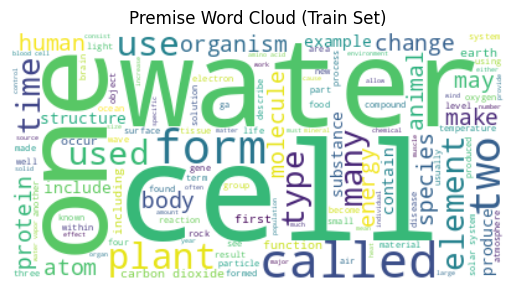

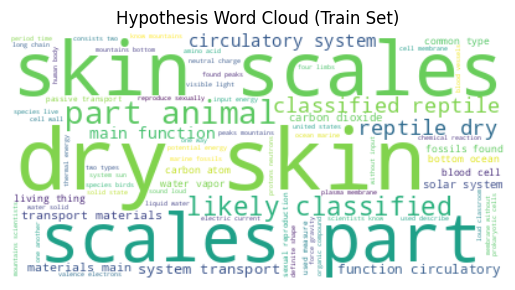

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
sww = stopwords.words('english')

for col in ["premise", "hypothesis"]:
  tokens = []
  # Remove punctuation, number, and stopword tokens temporarily
  for toks in tokenized_train_df[col]:
    tokens.extend([t.lower() for t in toks if t.isalpha() and t.lower() not in sww])
  wordcloud = WordCloud(background_color="white").generate(" ".join(tokens))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"{col.capitalize()} Word Cloud (Train Set)")
  plt.show()

# 3. Word Embedding

## 3.1 Token vocabulary

The vocabulary only includes tokens in train set with `frequency >= 3`.

Therefore, a token with low frequency will be regarded as \<UNK>.

E.g. the token "6.39" from the first premise.

In [ ]:
from collections import Counter

def vocab_coverage(vocab, dataset):
  total_tokens = 0
  oov_tokens = 0

  for tokens in dataset["premise"].tolist() + dataset["hypothesis"].tolist():
    for t in tokens:
      total_tokens += 1
      if t not in vocab:
        oov_tokens += 1

  coverage = 1 - (oov_tokens / total_tokens)
  return coverage, oov_tokens, total_tokens

def build_vocab(df, min_freq=3):
  counter = Counter()
  for col in ["premise", "hypothesis"]:
    for toks in df[col]:
      counter.update(toks)

  # special tokens
  vocab = {"<PAD>": 0,"<UNK>": 1}
  for token, freq in counter.items():
    if freq >= min_freq and token not in vocab:
      vocab[token] = len(vocab)

  return vocab

vocab = build_vocab(tokenized_train_df)
print("Vocab size:\t", {len(vocab)})
print("Sample vocab:\t", list(vocab.keys())[:20])

val_cov, val_oov, val_total = vocab_coverage(vocab, val_df)
test_cov, test_oov, test_total = vocab_coverage(vocab, test_df)
print(f"Val Coverage:\t{val_cov:.2%} ({val_total-val_oov}/{val_total})")
print(f"Test Coverage:\t{test_cov:.2%} ({test_total-test_oov}/{test_total})")

Vocab size:	 {8716}
Sample vocab:	 ['<PAD>', '<UNK>', 'pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', 'earth', 'days', 'per', 'day', 'the', 'about', 'geysers', '-', 'periodic', 'of', 'hot']
Val Coverage:	80.17% (188412/235003)
Test Coverage:	79.91% (295011/369158)


## 3.3 One-hot key embedding

Map each token to its one-hot key from the vocabulary.

In [ ]:
def word_to_index(df, vocab):
  df = df.copy()

  for col in ["premise", "hypothesis"]:
    df[col] = df[col].apply(lambda toks: [vocab.get(w, vocab["<UNK>"]) for w in toks])

  label_map = {"neutral": 0, "entails": 1}
  if "label" in df.columns:
    df["label"] = df["label"].map(label_map).fillna(-1).astype(int)

  return df

# One-hot key embedding
indexed_train_df = word_to_index(tokenized_train_df, vocab)
indexed_val_df = word_to_index(tokenized_val_df, vocab)
indexed_test_df = word_to_index(tokenized_test_df, vocab)

display(indexed_train_df.head())

,premise,hypothesis,label
0,"[2, 3, 4, 5, 6, 7, 8, 1, 9, 10]","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12]",0
1,"[1, 4, 11, 12, 13, 9, 3, 14, 6, 7]","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12]",1
2,"[15, 16, 17, 1, 18, 19, 20, 21, 13, 22, 18, 13...","[13, 22, 18, 13, 42, 44, 185, 1185, 50, 1049, ...",0
3,"[23, 24, 20, 25, 26, 27, 28, 29, 30, 20, 31, 3...","[36, 44, 2057, 55, 547, 24, 20, 29, 20, 31]",1
4,"[37, 38, 13, 9, 3, 5, 6, 7, 4, 11, 12, 39, 40,...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12]",1


# 4. Model Implementation

## 4.1 Training Configuration

### 4.1.1 Enable cuda GPU acceleration

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1.2 Shared hyperparameters


In [ ]:
from types import SimpleNamespace

shared = SimpleNamespace(
  vocab_size = len(vocab),
  embed_dim = 256,
  hidden_dim = 256,
  num_layers = 1,
  dropout = 0.1,
  num_classes = 2,      # len(label_mapping)
  label_mapping = {"neutral": 0, "entails": 1},
  batch_size = 128,
  learning_rate = 1e-3,
  total_epoch = 20,
  pad_idx = vocab["<PAD>"],
  unk_idx = vocab["<UNK>"],
)

### 4.1.3 Padding

In [ ]:
def pad(seq, max_len):
  return seq + [shared.pad_idx] * (max_len - len(seq))

def pad_seq(df):
  df = df.copy()

  max_prem = max(df["premise"].apply(len))
  max_hypo = max(df["hypothesis"].apply(len))

  df["premise"] = df["premise"].apply(lambda s: pad(s, max_prem))
  df["hypothesis"] = df["hypothesis"].apply(lambda s: pad(s, max_hypo))

  return df

# Padding
pad_train_df = pad_seq(indexed_train_df)
pad_val_df = pad_seq(indexed_val_df)
pad_test_df = pad_seq(indexed_test_df)

# Verification
pd.set_option("display.max_colwidth", 60)
display(pad_train_df.head())
pd.reset_option("display.max_colwidth")

,premise,hypothesis,label
0,"[2, 3, 4, 5, 6, 7, 8, 1, 9, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[1, 4, 11, 12, 13, 9, 3, 14, 6, 7, 0, 0, 0, 0, 0, 0, 0, ...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[15, 16, 17, 1, 18, 19, 20, 21, 13, 22, 18, 13, 9, 0, 0,...","[13, 22, 18, 13, 42, 44, 185, 1185, 50, 1049, 1776, 5, 9...",0
3,"[23, 24, 20, 25, 26, 27, 28, 29, 30, 20, 31, 32, 33, 34,...","[36, 44, 2057, 55, 547, 24, 20, 29, 20, 31, 0, 0, 0, 0, ...",1
4,"[37, 38, 13, 9, 3, 5, 6, 7, 4, 11, 12, 39, 40, 41, 13, 4...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12, 0, 0, 0, 0, 0, 0, 0, ...",1


### 4.1.4 Batching

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def make_batch(pad_df):
  batch_size = shared.batch_size

  premises_tensor = torch.tensor(pad_df["premise"].tolist())
  hypotheses_tensor = torch.tensor(pad_df["hypothesis"].tolist())
  labels_tensor = torch.tensor(pad_df["label"].tolist())

  dataset = TensorDataset(premises_tensor, hypotheses_tensor, labels_tensor)
  loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return loader

train_loader = make_batch(pad_train_df)
val_loader = make_batch(pad_val_df)
test_loader = make_batch(pad_test_df)

## 4.2 Model 1: The Vanilla NLI Classifier

This baseline model is inspired by the classic SNLI model proposed by [Bowman et al.](https://arxiv.org/abs/1508.05326)
* Single Bi-LSTM recurrent layer
* Dropout applied to encoders and classifier
* The value of `label` is either "neutral" or "entails"
* Validation set used for monitoring overfitting
* Remains affected by the OOV limitation
* No attention mechanism

Its ablation counterpart is inspired by the SA-NLI model proposed by [Li et al.](https://www.sciencedirect.com/science/article/pii/S0925231220304793#sec0017), which introduces **dual-attention mechanism** before concatenation.
* Inherit from the vanilla model to keep the ablation setup consistent
* Overrides the `forward()` method to change model architecture
* Combines both self-attention (within each sentence) and cross-attention (between premise and hypothesis)

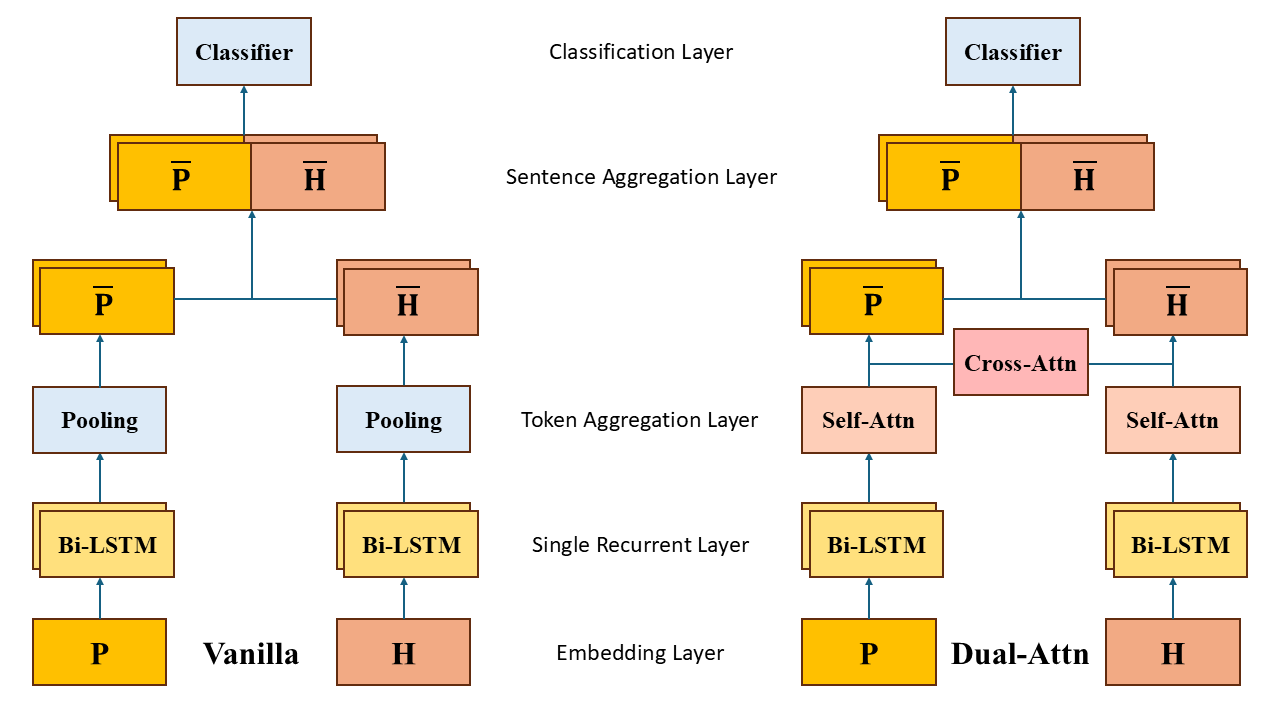

### 4.2.1 Ablation models

#### The vanilla NLI model without attention

In [ ]:
import torch.nn as nn

class Vanilla_NLI_Model(nn.Module):
  def __init__(self, shared):
    super().__init__()

    # Embedding layer
    self.prem_embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx) # discard <PAD>
    self.hypo_embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx) # discard <PAD>

    # Encoding Layer
    self.encoder = nn.LSTM(
      input_size=shared.embed_dim,
      hidden_size=shared.hidden_dim,
      num_layers=shared.num_layers,                  # single recurrent layer
      dropout=shared.dropout if shared.num_layers > 1 else 0.0, # disabled， dropout only applies between recurrent layers
      bidirectional=True,                       # Bi-LSTM
      batch_first=True                        # (B, T, E)
    )

    # Regularization to prevent overfitting
    self.dropout_encoder = nn.Dropout(shared.dropout)

    # Classification layer
    feat_dim = 2 * (2 * shared.hidden_dim)            # (prem + hypo) × BiLSTM(2H each) = 4H
    self.classifier = nn.Linear(feat_dim, shared.num_classes)    # simplest linear classifier

  def forward(self, prem_ids, hypo_ids):
    # Encode premise
    prem_embed = self.prem_embedding(prem_ids)            # (B, T_p, E)
    _, (prem_h, _) = self.encoder(prem_embed)           # return encoder_output, (prem_hidden_state, prem_cell_state)
    # Token Aggregation: concat two-direction final hidden states
    prem_vec = torch.cat([prem_h[-2], prem_h[-1]], dim=1)     # (B, 2H)
    prem_vec = self.dropout_encoder(prem_vec)            # apply dropout to concatenated premise hidden state

    # Encode hypothesis
    hypo_embed = self.hypo_embedding(hypo_ids)            # (B, T_h, E)
    _, (hypo_h, _) = self.encoder(hypo_embed)           # return encoder_output, (hypo_hidden_state, hypo_cell_state)
    # Token Aggregation: concat two-direction final hidden states
    hypo_vec = torch.cat([hypo_h[-2], hypo_h[-1]], dim=1)     # (B, 2H)
    hypo_vec = self.dropout_encoder(hypo_vec)            # apply dropout to concatenated hypothesis hidden state

    # Sentence Aggregation: combine premise and hypothesis as unified input for classifier
    combined = torch.cat([prem_vec, hypo_vec], dim=1)       # (B, 4H)
    combined = self.dropout_encoder(combined)            # apply dropout to combined premise-hypothesis representation

    # Classification
    logits = self.classifier(combined)                # (B, shared.num_classes)

    return logits

#### The vanilla NLI model with dual-attention

In [ ]:
import torch.nn as nn

class DualAttn_NLI_Model(Vanilla_NLI_Model):                # inherit vanilla NLI
  def __init__(self, shared):
    super().__init__(shared)

    self.self_attn = nn.Linear(2 * shared.hidden_dim, 1, bias=False)
    self.cross_attn = nn.Linear(2 * shared.hidden_dim, 2 * shared.hidden_dim, bias=False)

  def apply_self_attention(self, encoder_outputs):
    attn_scores = self.self_attn(encoder_outputs)            # (B, T, 1)
    attn_weights = torch.softmax(attn_scores, dim=1)          # (B, T, 1)
    attended_vec = torch.sum(attn_weights * encoder_outputs, dim=1) # (B, 2H)
    return attended_vec, attn_weights.squeeze(-1)

  def apply_cross_attention(self, src_vec, tar_vec):
    attn_scores = torch.bmm(src_vec.unsqueeze(1), tar_vec.unsqueeze(2)) # (B, 1, 1)
    attn_weights = torch.sigmoid(attn_scores)              # (B, 1, 1)
    context = attn_weights.squeeze(2) * tar_vec            # (B, 2H)
    return src_vec + context                      # (B, 2H) residual fusion

  def forward(self, prem_ids, hypo_ids, return_attn=False):
    # Encode premise
    prem_embed = self.prem_embedding(prem_ids)            # (B, T_p, E)
    prem_out, _ = self.encoder(prem_embed)             # return encoder_output, (prem_hidden_state, prem_cell_state)
    # Self-attention layer -> collect attention weights
    prem_self, prem_weights = self.apply_self_attention(prem_out)  # (B, 2H)
    prem_self = self.dropout_encoder(prem_self)    # apply dropout to attended premise hidden state

    # Encode hypothesis
    hypo_embed = self.hypo_embedding(hypo_ids)            # (B, T_h, E)
    hypo_out, _ = self.encoder(hypo_embed)             # return encoder_output, (hypo_hidden_state, hypo_cell_state)
    # Self-attention layer
    hypo_self, hypo_weights = self.apply_self_attention(hypo_out)         # (B, 2H)
    hypo_self = self.dropout_encoder(hypo_self)           # apply dropout to attended hypothesis hidden state

    # Cross-attention layer
    prem_cross = self.apply_cross_attention(prem_self, hypo_self)  # (B, 2H)
    hypo_cross = self.apply_cross_attention(hypo_self, prem_self)  # (B, 2H)

    # Sentence Aggregation: combine premise and hypothesis as unified input for classifier
    combined = torch.cat([prem_self, hypo_self], dim=1)       # (B, 4H)
    combined = self.dropout_encoder(combined)            # apply dropout to combined premise-hypothesis representation

    # Classification
    logits = self.classifier(combined)                # (B, shared.num_classes)

    if return_attn:
      return logits, prem_weights, hypo_weights
    else:
      return logits

### 4.2.2 Training (3+4 min)

In [ ]:
import torch.optim as optim

m1_vanilla_model = Vanilla_NLI_Model(shared).to(device)
m1_dual_attn_model = DualAttn_NLI_Model(shared).to(device)

m1_criterion = nn.CrossEntropyLoss()      # combine LogSoftmax and NLLLoss

vanilla_optimizer = optim.Adam(m1_vanilla_model.parameters(), lr=shared.learning_rate)
dual_attn_optimizer = optim.Adam(m1_dual_attn_model.parameters(), lr=shared.learning_rate)

In [ ]:
m1_vanilla_train_losses = []
m1_vanilla_val_losses = []

for epoch in range(shared.total_epoch):
  m1_vanilla_model.train()
  train_loss = 0

  # Training loop
  for prem, hypo, label in train_loader:
    prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

    # Forward
    logits = m1_vanilla_model(prem, hypo)
    loss = m1_criterion(logits, label)

    # Backward and optimize
    vanilla_optimizer.zero_grad()
    loss.backward()
    vanilla_optimizer.step()

    # Accumulate batch loss
    train_loss += loss.item()

  train_avg_loss = train_loss / len(train_loader)
  m1_vanilla_train_losses.append(train_avg_loss)

  # Validation
  m1_vanilla_model.eval()
  m1_val_loss = 0
  with torch.no_grad():
    for prem, hypo, label in val_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

      # Forward
      logits = m1_vanilla_model(prem, hypo)
      loss = m1_criterion(logits, label)

      # Accumulate batch loss
      m1_val_loss += loss.item()

  val_avg_loss = m1_val_loss / len(val_loader)
  m1_vanilla_val_losses.append(val_avg_loss)

  print(f"Vanilla Epoch: {epoch+1}/{shared.total_epoch}\tTrain Loss: {train_avg_loss:.4f}\tVal Loss: {val_avg_loss:.4f}")

Vanilla Epoch: 1/20	Train Loss: 0.4791	Val Loss: 0.5671
Vanilla Epoch: 2/20	Train Loss: 0.3344	Val Loss: 0.5708
Vanilla Epoch: 3/20	Train Loss: 0.2627	Val Loss: 0.5671
Vanilla Epoch: 4/20	Train Loss: 0.1941	Val Loss: 0.6587
Vanilla Epoch: 5/20	Train Loss: 0.1253	Val Loss: 0.7782
Vanilla Epoch: 6/20	Train Loss: 0.0721	Val Loss: 0.9377
Vanilla Epoch: 7/20	Train Loss: 0.0389	Val Loss: 1.0192
Vanilla Epoch: 8/20	Train Loss: 0.0194	Val Loss: 1.2049
Vanilla Epoch: 9/20	Train Loss: 0.0143	Val Loss: 1.2192
Vanilla Epoch: 10/20	Train Loss: 0.0172	Val Loss: 1.2098
Vanilla Epoch: 11/20	Train Loss: 0.0133	Val Loss: 1.4972
Vanilla Epoch: 12/20	Train Loss: 0.0094	Val Loss: 1.5749
Vanilla Epoch: 13/20	Train Loss: 0.0117	Val Loss: 1.5700
Vanilla Epoch: 14/20	Train Loss: 0.0146	Val Loss: 1.5768
Vanilla Epoch: 15/20	Train Loss: 0.0118	Val Loss: 1.7052
Vanilla Epoch: 16/20	Train Loss: 0.0164	Val Loss: 1.4687
Vanilla Epoch: 17/20	Train Loss: 0.0478	Val Loss: 1.4633
Vanilla Epoch: 18/20	Train Loss: 0.0060	

In [ ]:
m1_dual_attn_train_losses = []
m1_dual_attn_val_losses = []

for epoch in range(shared.total_epoch):
  m1_dual_attn_model.train()
  train_loss = 0

  # Training loop
  for prem, hypo, label in train_loader:
    prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

    # Forward
    logits = m1_dual_attn_model(prem, hypo)
    loss = m1_criterion(logits, label)

    # Backward and optimize
    dual_attn_optimizer.zero_grad()
    loss.backward()
    dual_attn_optimizer.step()

    # Accumulate batch loss
    train_loss += loss.item()

  train_avg_loss = train_loss / len(train_loader)
  m1_dual_attn_train_losses.append(train_avg_loss)

  # Validation
  m1_dual_attn_model.eval()
  m1_val_loss = 0
  with torch.no_grad():
    for prem, hypo, label in val_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

      # Forward
      logits = m1_dual_attn_model(prem, hypo)
      loss = m1_criterion(logits, label)

      # Accumulate batch loss
      m1_val_loss += loss.item()

  val_avg_loss = m1_val_loss / len(val_loader)
  m1_dual_attn_val_losses.append(val_avg_loss)

  print(f"Dual-Attn Epoch: {epoch+1}/{shared.total_epoch}\tTrain Loss: {train_avg_loss:.4f}\tVal Loss: {val_avg_loss:.4f}")

Dual-Attn Epoch: 1/20	Train Loss: 0.4935	Val Loss: 0.6668
Dual-Attn Epoch: 2/20	Train Loss: 0.3534	Val Loss: 0.5537
Dual-Attn Epoch: 3/20	Train Loss: 0.2852	Val Loss: 0.5800
Dual-Attn Epoch: 4/20	Train Loss: 0.2194	Val Loss: 0.6284
Dual-Attn Epoch: 5/20	Train Loss: 0.1408	Val Loss: 0.7293
Dual-Attn Epoch: 6/20	Train Loss: 0.1098	Val Loss: 0.9044
Dual-Attn Epoch: 7/20	Train Loss: 0.0987	Val Loss: 1.0942
Dual-Attn Epoch: 8/20	Train Loss: 0.0286	Val Loss: 1.2390
Dual-Attn Epoch: 9/20	Train Loss: 0.0132	Val Loss: 1.3283
Dual-Attn Epoch: 10/20	Train Loss: 0.0595	Val Loss: 0.8796
Dual-Attn Epoch: 11/20	Train Loss: 0.1483	Val Loss: 1.0953
Dual-Attn Epoch: 12/20	Train Loss: 0.0438	Val Loss: 1.3153
Dual-Attn Epoch: 13/20	Train Loss: 0.0160	Val Loss: 1.3214
Dual-Attn Epoch: 14/20	Train Loss: 0.0342	Val Loss: 1.4054
Dual-Attn Epoch: 15/20	Train Loss: 0.0077	Val Loss: 1.4260
Dual-Attn Epoch: 16/20	Train Loss: 0.0033	Val Loss: 1.6466
Dual-Attn Epoch: 17/20	Train Loss: 0.0046	Val Loss: 1.7216
Dual-A

### 4.2.3 Loss curves

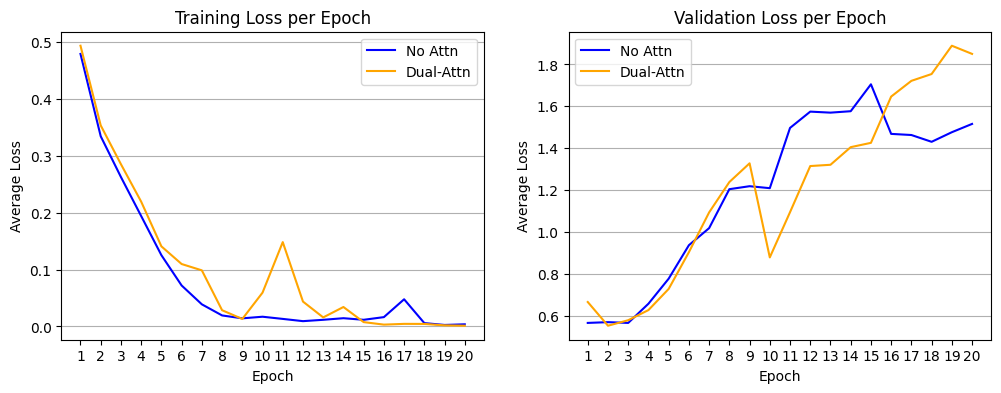

In [ ]:
import matplotlib.pyplot as plt

epoch = range(1, shared.total_epoch + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Training Loss
axes[0].plot(epoch, m1_vanilla_train_losses, color='blue', label='No Attn')
axes[0].plot(epoch, m1_dual_attn_train_losses, color='orange', label='Dual-Attn')
axes[0].set_title('Training Loss per Epoch')
axes[0].set_xticks(epoch)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average Loss')
axes[0].grid(axis='y')
axes[0].legend()

# Validation Loss
axes[1].plot(epoch, m1_vanilla_val_losses, color='blue', label='No Attn')
axes[1].plot(epoch, m1_dual_attn_val_losses, color='orange', label='Dual-Attn')
axes[1].set_title('Validation Loss per Epoch')
axes[1].set_xticks(epoch)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average Loss')
axes[1].grid(axis='y')
axes[1].legend()

plt.show()

### 4.2.4 Testing

In [ ]:
from sklearn.metrics import accuracy_score

# Testing

def evaluate_accuracy(model, test_loader, device, name):
  model.eval()
  preds, labels = [], []
  with torch.no_grad():
    for prem, hypo, label in test_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)
      logits = model(prem, hypo)
      pred = torch.argmax(logits, dim=1)
      preds.extend(pred.cpu().numpy())
      labels.extend(label.cpu().numpy())
  acc = accuracy_score(labels, preds)
  print(f"{name} Test Accuracy: {acc:.4f}")
  return acc, preds, labels

m1_vanilla_acc, m1_vanilla_preds, m1_vanilla_labels = evaluate_accuracy(m1_vanilla_model, test_loader, device, name="Vanilla")
m1_dual_attn_acc, m1_dual_attn_preds, m1_dual_attn_labels = evaluate_accuracy(m1_dual_attn_model, test_loader, device, name="Dual-Attn")

Vanilla Test Accuracy: 0.7087
Dual-Attn Test Accuracy: 0.6965


### 4.2.5 Classification Matrics

================== Vanilla BiLSTM NLI ==================
              precision    recall  f1-score   support

     neutral       0.73      0.82      0.77      1287
     entails       0.66      0.55      0.60       848

    accuracy                           0.71      2135
   macro avg       0.70      0.68      0.69      2135
weighted avg       0.70      0.71      0.70      2135


================= Dual-Attn BiLSTM NLI =================
              precision    recall  f1-score   support

     neutral       0.74      0.77      0.75      1287
     entails       0.63      0.59      0.61       848

    accuracy                           0.70      2135
   macro avg       0.68      0.68      0.68      2135
weighted avg       0.69      0.70      0.69      2135



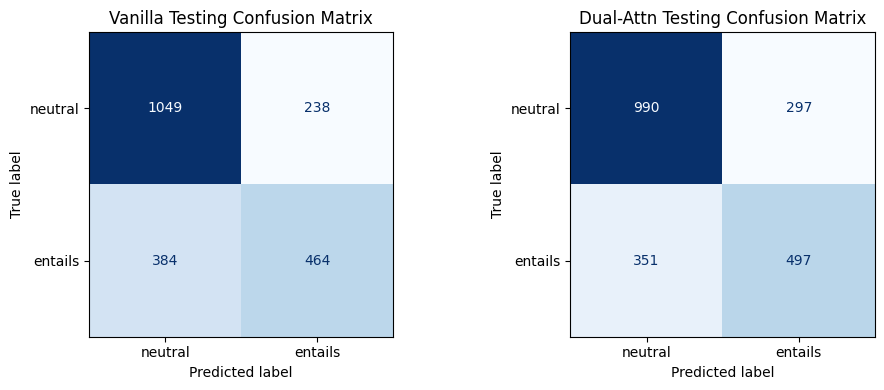

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Classification matrices
print("================== Vanilla BiLSTM NLI ==================")
print(classification_report(m1_vanilla_labels, m1_vanilla_preds, target_names=list(shared.label_mapping.keys())))

print("\n================= Dual-Attn BiLSTM NLI =================")
print(classification_report(m1_dual_attn_labels, m1_dual_attn_preds, target_names=list(shared.label_mapping.keys())))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cm_vanilla = confusion_matrix(m1_vanilla_labels, m1_vanilla_preds)
disp_vanilla = ConfusionMatrixDisplay(confusion_matrix=cm_vanilla, display_labels=list(shared.label_mapping.keys()))
disp_vanilla.plot(cmap="Blues", ax=axes[0], colorbar=False)
axes[0].set_title("Vanilla Testing Confusion Matrix")

cm_dual = confusion_matrix(m1_dual_attn_labels, m1_dual_attn_preds)
disp_dual = ConfusionMatrixDisplay(confusion_matrix=cm_dual, display_labels=list(shared.label_mapping.keys()))
disp_dual.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Dual-Attn Testing Confusion Matrix")

plt.tight_layout()
plt.show()

### 4.2.6 Attention Weights

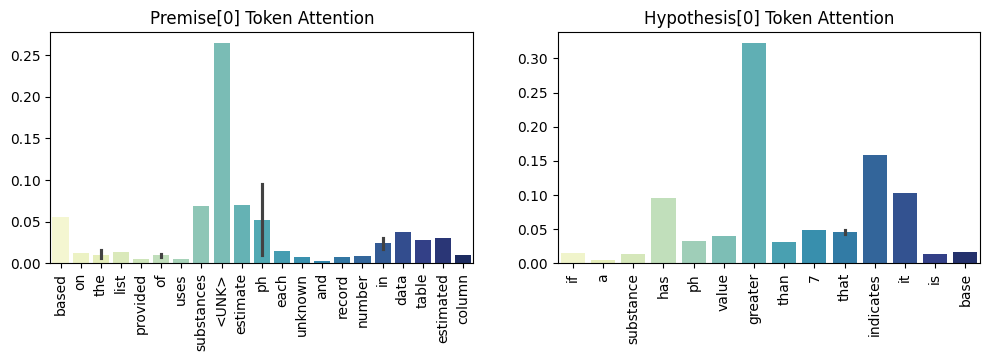

In [ ]:
sample = pad_test_df.iloc[0]
prem_ids = torch.tensor([sample["premise"]]).to(device)
hypo_ids = torch.tensor([sample["hypothesis"]]).to(device)

# Predict
m1_dual_attn_model.eval()
with torch.no_grad():
  logits, prem_weights, hypo_weights = m1_dual_attn_model(prem_ids, hypo_ids, return_attn=True)

id2word = {idx: word for word, idx in vocab.items()}
prem_tokens = [id2word[idx] for idx in sample["premise"] if idx != shared.pad_idx]
hypo_tokens = [id2word[idx] for idx in sample["hypothesis"] if idx != shared.pad_idx]
# Remove padding visualization
valid_len_prem = len(prem_tokens)
valid_len_hypo = len(hypo_tokens)
prem_attn_np = prem_weights[0, :valid_len_prem].cpu().numpy()
hypo_attn_np = hypo_weights[0, :valid_len_hypo].cpu().numpy()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.barplot(x=prem_tokens, y=prem_attn_np, hue=prem_tokens, palette="YlGnBu", legend=False, ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title("Premise[0] Token Attention")

sns.barplot(x=hypo_tokens, y=hypo_attn_np, hue=hypo_tokens, palette="YlGnBu", legend=False, ax=axes[1])
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title("Hypothesis[0] Token Attention")

plt.show()

### 4.2.7 Evaluation

In summary, the model struggles to predict OOV words, regardless of how much content it has learned from the training set.

#### Training Loss

The training loss of both models shows a similar trends that decreases rapidly and stabilizes around epoch 10, indicating that the model successfully fits the training data.

The train loss of the model with dual-attention often more stable than the one without attention.

The consistent convergence pattern suggests that thiese vanilla NLI classicier models are capable of capturing the sequence patterns within the training distribution.

#### Validation Loss

The validation loss rises steadily throughout training, revealing a clear sign of overfitting.

This outcome is expected. Since the word-to-index vocabulary was intentionally built only from the training set

As a result, unseen or rare tokens are replaced by the \<UNK> tag, leading to higher loss and reduced generalization capability.

#### Classification Matrics

The dual-attention mechanism does not notably improve overall accuracy, but enhances the prediction of the **true positive** label "entails". This is likely due to label imbalance in training set:

Two-thirds of the training data are "neutral", while the validation and test sets are balanced. This make the vanilla model to underperform on "entails" examples.

#### Attention Weights

The attention heatmaps indicate that the trained dual-attention model successfully highlights key science-specific tokens after token-level self-attention layer.

In the premise[0], the model places higher attention on *\<UNK>*, *substances*, and *estimate*, indicating its focus on task-relevant scientific expressions.

In the hypothesis[0], the strongest attention lies on *greater* and *indicates*, suggesting that the model effectively captures comparative and inferential cues.

## 4.3 Model 2: The Bi-LSTM Self-Attention NLI Classifier

### 4.3.1 Model

In [ ]:
# ============================================================
# NLI BiLSTM with Attention (Classifier + Training Loop)
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

class NLI_BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def attention_pool(self, lstm_out):
        attn_weights = F.softmax(self.attn(lstm_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)   # [batch, hidden_dim*2]
        return context

    def forward(self, premise, hypothesis):
        # Encode premise
        prem_embed = self.embedding(premise)
        prem_out, _ = self.bilstm(prem_embed)
        prem_vec = self.attention_pool(prem_out)

        # Encode hypothesis
        hyp_embed = self.embedding(hypothesis)
        hyp_out, _ = self.bilstm(hyp_embed)
        hyp_vec = self.attention_pool(hyp_out)

        # Combine
        combined = torch.cat([
            prem_vec,
            hyp_vec,
            torch.abs(prem_vec - hyp_vec),
            prem_vec * hyp_vec
        ], dim=1)

        logits = self.fc(combined)
        return logits

### 4.3.2 Training (4 min)

In [ ]:
# Assuming label_mapping and shared are already defined
# Define the number of classes from the label_mapping

m2_self_attn_model = NLI_BiLSTM_Attention(
    vocab_size=len(vocab),
    embed_dim=shared.embed_dim,
    hidden_dim=shared.hidden_dim,
    num_classes=shared.num_classes,
    pad_idx=shared.pad_idx
).to(device)

m2_criterion = nn.CrossEntropyLoss()
m2_optimizer = torch.optim.Adam(m2_self_attn_model.parameters(), lr=shared.learning_rate)

m2_train_losses, m2_val_losses = [], []

for epoch in range(shared.total_epoch):
    # ---------- TRAIN ----------
    m2_self_attn_model.train()
    running_loss, preds, labels_all = 0, [], []
    for premise, hypothesis_in, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{shared.total_epoch}"):
        premise, hypothesis_in, labels = premise.to(device), hypothesis_in.to(device), labels.to(device)
        m2_optimizer.zero_grad()
        outputs = m2_self_attn_model(premise, hypothesis_in)
        loss = m2_criterion(outputs, labels)
        loss.backward()
        m2_optimizer.step()

        running_loss += loss.item()
        preds.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    train_acc = accuracy_score(labels_all, preds)
    train_loss = running_loss / len(train_loader)
    m2_train_losses.append(train_loss)

    # ---------- VALIDATION ----------
    m2_self_attn_model.eval()
    m2_val_loss, m2_val_preds, m2_val_labels = 0, [], []
    with torch.no_grad():
        for premise, hypothesis_in, labels in val_loader:
            premise, hypothesis_in, labels = premise.to(device), hypothesis_in.to(device), labels.to(device)
            outputs = m2_self_attn_model(premise, hypothesis_in)
            loss = m2_criterion(outputs, labels)
            m2_val_loss += loss.item()
            m2_val_preds.extend(outputs.argmax(1).cpu().numpy())
            m2_val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(m2_val_labels, m2_val_preds)
    m2_val_loss /= len(val_loader)
    m2_val_losses.append(m2_val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={m2_val_loss:.4f}, Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

Epoch 1/20: 100%|██████████| 191/191 [00:11<00:00, 16.37it/s]


Epoch 1: Train Loss=0.4884, Val Loss=0.6332, Train Acc=0.761, Val Acc=0.702


Epoch 2/20: 100%|██████████| 191/191 [00:11<00:00, 16.53it/s]


Epoch 2: Train Loss=0.3316, Val Loss=0.4780, Train Acc=0.863, Val Acc=0.764


Epoch 3/20: 100%|██████████| 191/191 [00:11<00:00, 16.53it/s]


Epoch 3: Train Loss=0.2324, Val Loss=0.5404, Train Acc=0.909, Val Acc=0.763


Epoch 4/20: 100%|██████████| 191/191 [00:11<00:00, 16.52it/s]


Epoch 4: Train Loss=0.1251, Val Loss=0.7391, Train Acc=0.956, Val Acc=0.751


Epoch 5/20: 100%|██████████| 191/191 [00:11<00:00, 16.52it/s]


Epoch 5: Train Loss=0.0529, Val Loss=0.9121, Train Acc=0.983, Val Acc=0.758


Epoch 6/20: 100%|██████████| 191/191 [00:11<00:00, 15.96it/s]


Epoch 6: Train Loss=0.0277, Val Loss=1.2100, Train Acc=0.992, Val Acc=0.744


Epoch 7/20: 100%|██████████| 191/191 [00:11<00:00, 16.09it/s]


Epoch 7: Train Loss=0.0222, Val Loss=1.1774, Train Acc=0.993, Val Acc=0.739


Epoch 8/20: 100%|██████████| 191/191 [00:11<00:00, 16.35it/s]


Epoch 8: Train Loss=0.0175, Val Loss=1.2502, Train Acc=0.995, Val Acc=0.739


Epoch 9/20: 100%|██████████| 191/191 [00:11<00:00, 16.53it/s]


Epoch 9: Train Loss=0.0149, Val Loss=1.3015, Train Acc=0.996, Val Acc=0.754


Epoch 10/20: 100%|██████████| 191/191 [00:12<00:00, 15.76it/s]


Epoch 10: Train Loss=0.0157, Val Loss=1.4054, Train Acc=0.995, Val Acc=0.750


Epoch 11/20: 100%|██████████| 191/191 [00:12<00:00, 15.54it/s]


Epoch 11: Train Loss=0.0176, Val Loss=1.2865, Train Acc=0.995, Val Acc=0.755


Epoch 12/20: 100%|██████████| 191/191 [00:11<00:00, 16.55it/s]


Epoch 12: Train Loss=0.0075, Val Loss=1.4401, Train Acc=0.998, Val Acc=0.760


Epoch 13/20: 100%|██████████| 191/191 [00:11<00:00, 16.53it/s]


Epoch 13: Train Loss=0.0072, Val Loss=1.5128, Train Acc=0.998, Val Acc=0.740


Epoch 14/20: 100%|██████████| 191/191 [00:11<00:00, 16.55it/s]


Epoch 14: Train Loss=0.0118, Val Loss=1.3424, Train Acc=0.996, Val Acc=0.760


Epoch 15/20: 100%|██████████| 191/191 [00:11<00:00, 16.55it/s]


Epoch 15: Train Loss=0.0145, Val Loss=1.2784, Train Acc=0.996, Val Acc=0.752


Epoch 16/20: 100%|██████████| 191/191 [00:11<00:00, 16.33it/s]


Epoch 16: Train Loss=0.0093, Val Loss=1.4159, Train Acc=0.997, Val Acc=0.747


Epoch 17/20: 100%|██████████| 191/191 [00:11<00:00, 16.31it/s]


Epoch 17: Train Loss=0.0057, Val Loss=1.7067, Train Acc=0.998, Val Acc=0.747


Epoch 18/20: 100%|██████████| 191/191 [00:11<00:00, 16.16it/s]


Epoch 18: Train Loss=0.0045, Val Loss=1.7202, Train Acc=0.999, Val Acc=0.732


Epoch 19/20: 100%|██████████| 191/191 [00:11<00:00, 16.56it/s]


Epoch 19: Train Loss=0.0061, Val Loss=2.0360, Train Acc=0.998, Val Acc=0.732


Epoch 20/20: 100%|██████████| 191/191 [00:11<00:00, 16.05it/s]


Epoch 20: Train Loss=0.0071, Val Loss=1.5496, Train Acc=0.998, Val Acc=0.748


### 4.3.3 Evaluation

Classification Report:
              precision    recall  f1-score   support

     neutral       0.71      0.83      0.76       650
     entails       0.80      0.67      0.73       662

    accuracy                           0.75      1312
   macro avg       0.75      0.75      0.75      1312
weighted avg       0.76      0.75      0.75      1312



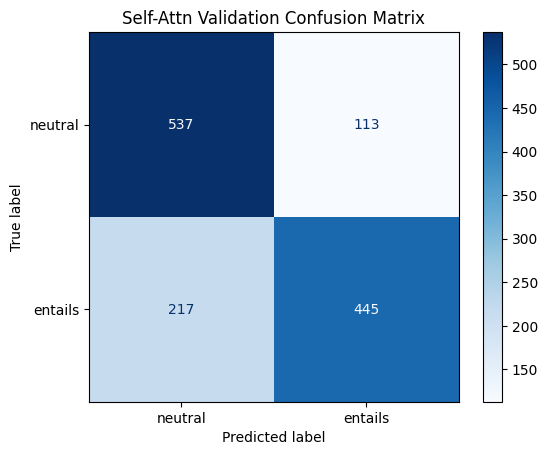

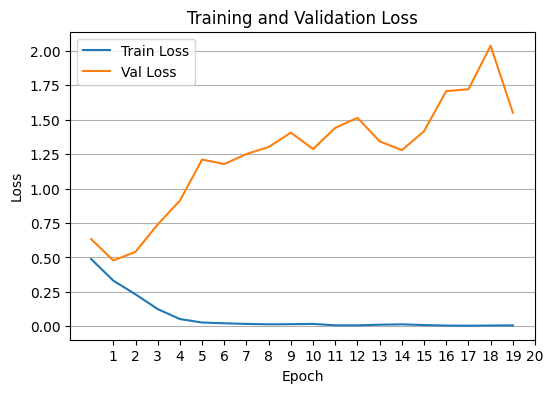

In [ ]:
# Final evaluation metrics
print("Classification Report:")
print(classification_report(m2_val_labels, m2_val_preds, target_names=list(shared.label_mapping.keys())))

# Confusion Matrix
cm = confusion_matrix(m2_val_labels, m2_val_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(shared.label_mapping.keys())).plot(cmap='Blues')
plt.title("Self-Attn Validation Confusion Matrix")
plt.show()

# Plot Loss Curves
epoch = range(1, shared.total_epoch + 1)
plt.figure(figsize=(6,4))
plt.plot(m2_train_losses, label="Train Loss")
plt.plot(m2_val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.xticks(epoch)
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(axis='y')
plt.show()

## 4.4 Model 3: The Transformer Encoder NLI

#### 4.4.1 Model

In [ ]:
# --------------------------------------------------
# Transformer Encoder NLI Classifier
# --------------------------------------------------
import torch
import torch.nn as nn

class Transformer_NLI_Model(nn.Module):
    def __init__(self, shared):
        super().__init__()
        self.embedding = nn.Embedding(shared.vocab_size, shared.embed_dim,
                                      padding_idx=shared.pad_idx)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=shared.embed_dim,
            nhead=8,
            dim_feedforward=shared.hidden_dim * 2,
            dropout=shared.dropout,
            activation='relu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.dropout = nn.Dropout(shared.dropout)
        self.fc = nn.Linear(shared.embed_dim * 2, shared.num_classes)

    def forward(self, prem_ids, hypo_ids):
        # Embedding
        prem_embed = self.embedding(prem_ids)
        hypo_embed = self.embedding(hypo_ids)

        # Encode
        prem_enc = self.encoder(prem_embed)
        hypo_enc = self.encoder(hypo_embed)

        # Pooling (mean over time)
        prem_vec = prem_enc.mean(dim=1)
        hypo_vec = hypo_enc.mean(dim=1)

        # Concatenate and classify
        combined = torch.cat([prem_vec, hypo_vec], dim=1)
        logits = self.fc(self.dropout(combined))
        return logits

#### 4.4.2 Training (6 min)

In [ ]:
# === Model 3 Training ===

m3_train_losses, m3_val_losses = [], []

m3_transformer_model = Transformer_NLI_Model(shared).to(device)
m3_criterion = nn.CrossEntropyLoss()
m3_optimizer = optim.Adam(m3_transformer_model.parameters(), lr=shared.learning_rate)

for epoch in range(shared.total_epoch):
    m3_transformer_model.train()
    total_loss = 0
    for prem, hypo, label in train_loader:
        prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

        m3_optimizer.zero_grad()
        logits = m3_transformer_model(prem, hypo)
        loss = m3_criterion(logits, label)
        loss.backward()
        m3_optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    m3_train_losses.append(train_loss)

    m3_transformer_model.eval()
    val_loss = 0
    with torch.no_grad():
        for prem, hypo, label in val_loader:
            prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)
            logits = m3_transformer_model(prem, hypo)
            loss = m3_criterion(logits, label)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    m3_val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

[Epoch 1] Train Loss: 0.5132, Val Loss: 0.6347
[Epoch 2] Train Loss: 0.3877, Val Loss: 0.5652
[Epoch 3] Train Loss: 0.3215, Val Loss: 0.5742
[Epoch 4] Train Loss: 0.2816, Val Loss: 0.5674
[Epoch 5] Train Loss: 0.2356, Val Loss: 0.7046
[Epoch 6] Train Loss: 0.2006, Val Loss: 0.7502
[Epoch 7] Train Loss: 0.1821, Val Loss: 0.7588
[Epoch 8] Train Loss: 0.1561, Val Loss: 0.8735
[Epoch 9] Train Loss: 0.1080, Val Loss: 1.0191
[Epoch 10] Train Loss: 0.0931, Val Loss: 1.1464
[Epoch 11] Train Loss: 0.0889, Val Loss: 1.1088
[Epoch 12] Train Loss: 0.0762, Val Loss: 1.1957
[Epoch 13] Train Loss: 0.0711, Val Loss: 1.1592
[Epoch 14] Train Loss: 0.0607, Val Loss: 1.2110
[Epoch 15] Train Loss: 0.0557, Val Loss: 1.3291
[Epoch 16] Train Loss: 0.0559, Val Loss: 1.3877
[Epoch 17] Train Loss: 0.0504, Val Loss: 1.4921
[Epoch 18] Train Loss: 0.0499, Val Loss: 1.4421
[Epoch 19] Train Loss: 0.0405, Val Loss: 1.5206
[Epoch 20] Train Loss: 0.0410, Val Loss: 1.6484


#### 4.4.3 Evaluation

Classification Report (Model 3 - Transformer, validation):
              precision    recall  f1-score   support

     neutral       0.70      0.61      0.65       650
     entails       0.66      0.74      0.70       662

    accuracy                           0.68      1312
   macro avg       0.68      0.68      0.68      1312
weighted avg       0.68      0.68      0.68      1312

F1 (macro) - Model 3: 0.6768


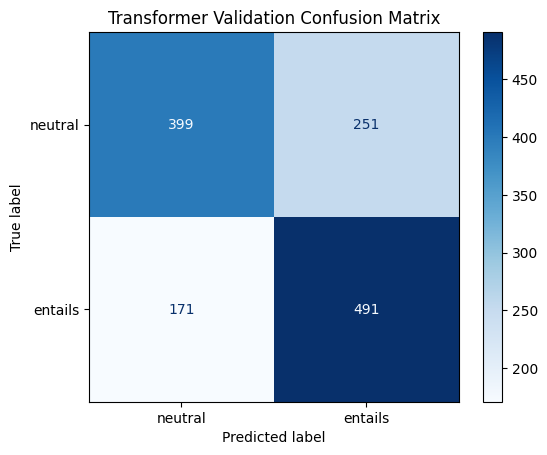

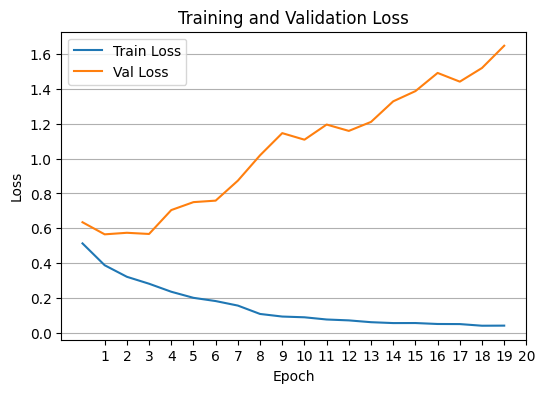

In [ ]:
# === Model 3 Evaluation ===

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Collect predictions and labels for Model 3 only
m3_labels_all, m3_preds = [], []

m3_transformer_model.eval()
with torch.no_grad():
    for prem, hypo, label in val_loader:
        prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)
        logits = m3_transformer_model(prem, hypo)
        m3_preds.extend(logits.argmax(1).cpu().numpy())
        m3_labels_all.extend(label.cpu().numpy())

# Classification report
print("Classification Report (Model 3 - Transformer, validation):")
print(classification_report(m3_labels_all, m3_preds, target_names=list(shared.label_mapping.keys())))

# Macro F1 for quick reference
f1_m3 = f1_score(m3_labels_all, m3_preds, average='macro')
print(f"F1 (macro) - Model 3: {f1_m3:.4f}")

# Confusion matrix
cm_m3 = confusion_matrix(m3_labels_all, m3_preds)
ConfusionMatrixDisplay(confusion_matrix=cm_m3, display_labels=list(shared.label_mapping.keys())).plot(cmap='Blues')
plt.title("Transformer Validation Confusion Matrix")
plt.show()

# Loss curves for Model 3
epoch = range(1, shared.total_epoch + 1)
plt.figure(figsize=(6, 4))
plt.plot(m3_train_losses, label='Train Loss')
plt.plot(m3_val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.xticks(epoch)
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(axis='y')
plt.show()